# 2. Generating a Sample using MS1 Controller

In this notebook, we demonstrate how ViMMS can be used to generate a full-scan mzML file from a single sample. This corresponds to Section 3.1 of the paper.

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../..')

In [4]:
import os
from pathlib import Path
import pylab as plt

In [5]:
from vimms.MassSpec import IndependentMassSpectrometer
from vimms.Controller import SimpleMs1Controller
from vimms.Environment import Environment
from vimms.Common import POSITIVE, load_obj, save_obj, set_log_level_debug, set_log_level_warning
from vimms.ChemicalSamplers import DatabaseFormulaSampler, MZMLRTandIntensitySampler, MZMLChromatogramSampler, MZMLMS2Sampler
from vimms.Roi import RoiParams
from vimms.Chemicals import ChemicalMixtureCreator

Load previously trained spectral feature database and the list of extracted metabolites, created in **01. Download Data.ipynb**.

In [6]:
base_dir = os.path.abspath('example_data')
hmdb = load_obj(Path(base_dir, 'hmdb_compounds.p'))

## Create Chemicals

Define an output folder containing our results

In [7]:
out_dir = Path('results', 'MS1_single')

Here we generate the chemical objects that will be used in the sample. The chemical objects are generated by sampling from metabolites in the HMDB database.

#### Sample m/z values from the chemical formulae in HMDB

In [8]:
HMDB = os.path.join(base_dir, 'hmdb_compounds.p')
hmdb = load_obj(HMDB)

In [9]:
# create a database formula sampler that will sample from HMDB with m/z between 100 and 1000
df = DatabaseFormulaSampler(hmdb, min_mz=100, max_mz=1000)

Plot sampled m/z distribution of formulae

2022-02-24 17:37:30.162 | DEBUG    | vimms.ChemicalSamplers:sample:73 - 73822 unique formulas in filtered database
2022-02-24 17:37:30.169 | DEBUG    | vimms.ChemicalSamplers:sample:79 - Sampled formulas


(array([ 48.,  80.,  68.,  61.,  59.,  51.,  72., 145., 230., 186.]),
 array([100.0524295 , 187.92395065, 275.7954718 , 363.66699295,
        451.53851411, 539.41003526, 627.28155641, 715.15307756,
        803.02459871, 890.89611986, 978.76764101]),
 <BarContainer object of 10 artists>)

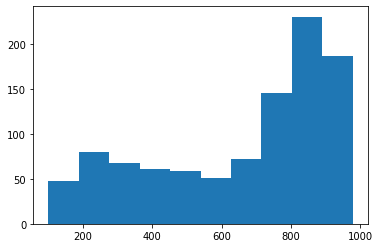

In [10]:
samples = df.sample(1000)
mz_list = [s[0].mass for s in samples]
plt.hist(mz_list)

Define the mzML file from which we'll sample various distributions for generating data, e.g. RT, intensity, chromatograms, MS2 spectra.

Here we set a very high threshold (1.75E5) on the minimum MS1 intensity of chemicals to be considered when generating various distributions. 
This is to allow the notebook to run fast. For a more accurate simulation, you should lower this to a much lower value, e.g. 1000

In [11]:
MZML = os.path.join(base_dir, 'Beer_multibeers_1_T10_POS.mzML')

In [12]:
min_ms1_intensity = 1.75E5
roi_params = RoiParams(min_intensity=min_ms1_intensity)

#### Sample RT and intensity values from an actual experimental mzML file

In [13]:
ri = MZMLRTandIntensitySampler(MZML, roi_params=roi_params)

2022-02-24 17:37:41.695 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 9423 scans


Plot sampled RT and intensity distributions

(array([945.,  32.,   9.,   6.,   2.,   2.,   1.,   2.,   0.,   1.]),
 array([ 175011.40624873,  979480.27510589, 1783949.14396306,
        2588418.01282022, 3392886.88167739, 4197355.75053455,
        5001824.61939172, 5806293.48824888, 6610762.35710605,
        7415231.22596321, 8219700.09482038]),
 <BarContainer object of 10 artists>)

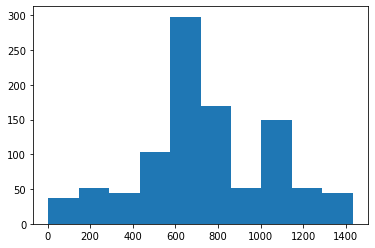

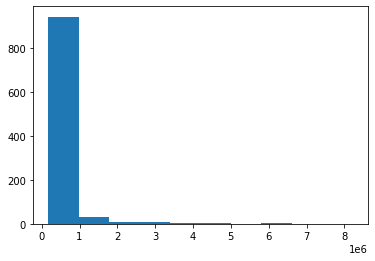

In [14]:
rt_list = []
intensity_list = []

for i in range(1000):
    a,b = ri.sample(None) #argument is a formula, but is ignored at the moment
    rt_list.append(a)
    intensity_list.append(b)

plt.figure()
plt.hist(rt_list)
plt.figure()
plt.hist(intensity_list)

#### Sample chromatograms from mzML file

In [15]:
cs = MZMLChromatogramSampler(MZML, roi_params=roi_params)

2022-02-24 17:38:27.433 | DEBUG    | vimms.ChemicalSamplers:_extract_rois:370 - Extracted 25281 good ROIs from C:\Users\joewa\Work\git\vimms\examples\01. vimms (Wandy et al 2019)\example_data\Beer_multibeers_1_T10_POS.mzML


#### Sample MS2 spectra from mzML file

In [16]:
ms = MZMLMS2Sampler(MZML)

2022-02-24 17:38:32.715 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 9423 scans
2022-02-24 17:38:33.000 | DEBUG    | vimms.ChemicalSamplers:_filter_scans:607 - 7672 MS2 scansn remaining


## Put everything together

In [17]:
cm = ChemicalMixtureCreator(df, rt_and_intensity_sampler=ri, chromatogram_sampler=cs, ms2_sampler=ms)
dataset = cm.sample(6500, 2)

2022-02-24 17:38:38.527 | DEBUG    | vimms.ChemicalSamplers:sample:73 - 73822 unique formulas in filtered database
2022-02-24 17:38:38.530 | DEBUG    | vimms.ChemicalSamplers:sample:79 - Sampled formulas
2022-02-24 17:38:40.094 | DEBUG    | vimms.Chemicals:sample:324 - Sampled rt and intensity values and chromatograms


In [18]:
save_obj(dataset, Path(out_dir, 'dataset.p'))

2022-02-24 17:38:57.424 | INFO     | vimms.Common:save_obj:329 - Saving <class 'list'> to results\MS1_single\dataset.p


In [19]:
for chem in dataset[0:10]:
    print(chem)

KnownChemical - 'C15H20O4' rt=1208.11 max_intensity=213143.43
KnownChemical - 'C11H11N3O5' rt=353.05 max_intensity=243325.30
KnownChemical - 'C22H24O12' rt=1126.52 max_intensity=237176.34
KnownChemical - 'C13H16O10' rt=1122.85 max_intensity=241761.51
KnownChemical - 'C45H72O5' rt=498.95 max_intensity=246263.14
KnownChemical - 'C46H88O6' rt=1139.00 max_intensity=200250.34
KnownChemical - 'C41H78O6' rt=1409.41 max_intensity=205325.88
KnownChemical - 'C54H94O6' rt=1123.56 max_intensity=1023507.32
KnownChemical - 'C49H94O6' rt=115.44 max_intensity=211908.64
KnownChemical - 'C12H14O6S' rt=597.69 max_intensity=219664.64


## Run MS1 controller on the samples and generate .mzML files

In [20]:
set_log_level_warning()

1

In [21]:
rt_range = [(0, 1440)]
min_rt = rt_range[0][0]
max_rt = rt_range[0][1]

In [22]:
# set the log level to WARNING so we don't see too many messages when environment is running
set_log_level_warning()

2

In [23]:
mass_spec = IndependentMassSpectrometer(POSITIVE, dataset)
controller = SimpleMs1Controller()

In [24]:
# create an environment to run both the mass spec and controller
env = Environment(mass_spec, controller, min_rt, max_rt, progress_bar=True)

# run the simulation
env.run()

  0%|          | 0/1440 [00:00<?, ?it/s]

Simulated results are saved to the following .mzML file and can be viewed in tools like [ToppView](https://pubs.acs.org/doi/abs/10.1021/pr900171m) or using other mzML file viewers.

In [25]:
mzml_filename = 'ms1_controller.mzML'
env.write_mzML(out_dir, mzml_filename)